# Genetic attribution overview

In this notebook we overview the [Genetic Engineering Attribution competition in Driven Data](https://www.drivendata.org/competitions/63/genetic-engineering-attribution/).   

In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import requests
from tqdm import tqdm
from collections import OrderedDict

CPU times: user 1.12 s, sys: 145 ms, total: 1.27 s
Wall time: 5.15 s


## Loading data

In [3]:
%%time
#parent_dir = "/content/genetic_engineering_attribution"
parent_dir = "/home/rio/genetic_engineering_attribution"

### train/val/test directories
train_dir = os.path.join(parent_dir,"train") 
val_dir = os.path.join(parent_dir,"val")
test_dir = os.path.join(parent_dir,"test")

### Paths to csvs
train_path = os.path.join(train_dir,"train.csv")
val_path = os.path.join(val_dir,"val.csv")
test_path = os.path.join(test_dir,"test.csv")

### Dataframes
df_train = pd.read_csv(train_path,index_col=0)
df_val = pd.read_csv(val_path,index_col=0)
df_test = pd.read_csv(test_path,index_col=0)

### Printing shapes:
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_val: {df_val.shape}")
print(f"Shape of df_test: {df_test.shape}")

Shape of df_train: (50413, 43)
Shape of df_val: (12604, 43)
Shape of df_test: (18816, 43)
CPU times: user 3.5 s, sys: 520 ms, total: 4.02 s
Wall time: 7.15 s


In [4]:
df_train.head()

,sequence_id,lab_id,sequence,seq_length,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
4350,SMVSS,I7FXTVDP,GACGGATCGGGAGATCTCCCGATCCCCTATGGTGCACTCTCAGTAC...,7723,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10470,6MC5M,I7FXTVDP,GCTAGAGCCGTGAACGACAGGGCGAACGCCAGCCCGCCGACGGCGA...,10550,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
30997,BHOUO,P3Q11IAK,GGCTTTGTTAGCAGCCGGATCCTTATCAGTCTGCGGCAGGATTGGC...,1085,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29915,EI1J7,I7FXTVDP,GACGGATCGGGAGATCTCCCGATCCCCTATGGTGCACTCTCAGTAC...,9216,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19843,NVS4Z,AMV4U0A0,TATACGACTCACTATAGGGCGAATTGGGCCCTCTAGATGCATGCTC...,975,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Histogram of sequence lengths

For this reason, we can, without much loss of generality, generate datasets with DNA snipetts of predefined length. Let us do this with 128 long snippets.

In [17]:
max_ = np.quantile(df_train.seq_length.values,0.999)

In [18]:
max_

22731.936000000074

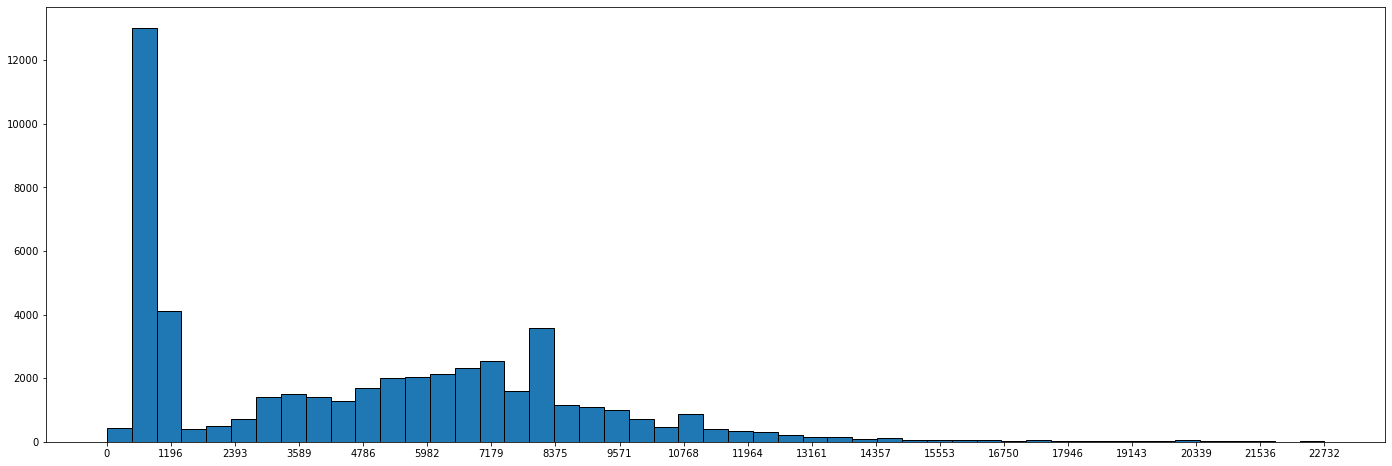

In [31]:
fig, ax = plt.subplots(figsize=(24,8))
max_ = np.quantile(df_train.seq_length.values,0.999)
n_bins=50
bins = np.linspace(0,max_,50)
xticks = np.linspace(0,max_,20)
ax.hist(df_train.seq_length.values,bins=bins,histtype="bar",edgecolor='black')
ax.set_xticks(xticks)

In [32]:
df_train.seq_length.describe()

count    50413.000000
mean      4846.758773
std       3897.863677
min         20.000000
25%        910.000000
50%       4746.000000
75%       7511.000000
max      60099.000000
Name: seq_length, dtype: float64

In [14]:
np.max(df_train.seq_length.values)

60099

In [35]:
df_train.lab_id.value_counts()

I7FXTVDP    6651
RKJHZGDQ    2219
GTVTUGVY    2140
A18S09P2     846
Q2K8NHZY     785
            ... 
03GRNN7N       2
W2DYAZID       2
0L3Y6ZB2       1
WB78G3XF       1
ON9AXMKF       1
Name: lab_id, Length: 1314, dtype: int64

In [43]:
np.quantile(df_train.seq_length.values,0.001)

165.41199999999998

## Generating l_snippets

As we shall see next, the vast majority of DNA sequences is longer than 100.

In [236]:
np.quantile(df_train.seq_length.values,0.001)

165.41199999999998

We now code a function to generate l-snippets.

In [237]:
def sample_window(array_of_lengths, l):
    #print("array_of_lengths: ", array_of_lengths)
    sampled_lower_bounds = [np.random.randint(0,(length - l)) for length in array_of_lengths]
    sampled_upper_bounds = [lb + l for lb in sampled_lower_bounds]
    sampled_windows = np.array([sampled_lower_bounds, sampled_upper_bounds]).T
    return sampled_windows
    
def generate_snippets(df, l, min_seq_length=None, size=None, replace = False, p=None):
    if min_seq_length is None:
        min_seq_length = l+1
    df_sampled = df[df.seq_length>=min_seq_length].copy()
    ### selecting indices
    #a, p, replace = df.index.values, None, False
    a = df_sampled.index.values
    if size is None:
        size = len(a)
    else:
        if p == "seq_length":
            p = df_sampled.seq_length.values/np.sum(df_sampled.seq_length.values)
            replace = True
    #print("a: ", a, type(a))
    #print("size: ", size, type(size))
    #print("replace: ", replace, type(replace))
    #print("p: ", p, type(p))
    sampled_ixs = np.random.choice(a, size, replace, p)
    #print("sampled_ixs: ", sampled_ixs)
    df_sampled = df_sampled.loc[sampled_ixs,:] 
    array_of_lengths = df_sampled.seq_length.values
    #if np.any(array_of_lengths<min_seq_length):
    #    print("Found one!")
    sampled_windows = sample_window(array_of_lengths, l) 
    df_sampled.loc[:,"sequence"] = [seq[l:u] for seq,(l,u) in zip(df_sampled.sequence.values, sampled_windows)]
    df_sampled.loc[:,"seq_length"] = [len(seq) for seq in df_sampled.sequence.values]
    #return df_sampled,sampled_windows, array_of_lengths, sampled_ixs
    return df_sampled

In [238]:
%%time
np.random.seed(8469)
l = 100
min_seq_length=None
#snipps, windows, lengths, sampled_ixs = generate_snippets(df_train, l, min_seq_length, size=None, replace = False, p=None)
snipps = generate_snippets(df_train, l, min_seq_length, size=None, replace = False, p=None)

CPU times: user 311 ms, sys: 15.5 ms, total: 326 ms
Wall time: 328 ms


In [239]:
#windows

In [240]:
snipps

,sequence_id,lab_id,sequence,seq_length,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
32638,RC0V4,I7FXTVDP,TTGTTTTTCTTTAGCTTCCTCATATTTGTCAGCTAAACGCTCAGCC...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52623,DXZI2,I7FXTVDP,GGCCTCAGCAGCCCATGACCCATCGAGAAACTGCACCTGTTTCCCA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6933,QQG0U,I7FXTVDP,ACAGATCGCTGAGATAGGTGCCTCACTGATTAAGCATTGGTAACTG...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52836,5EP4L,MULMC195,TCAAGTCAGAGGTGGCGAAACCCGACAGGACTATAAAGATACCAGG...,100,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46372,OGD0Z,I7FXTVDP,AGCTCTTTGACAAGATCCTTCTGATGGCCGAGGGCAGGGTAGCTTT...,100,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17397,SZBWH,TNR495LD,GGGCGGGACATGTTGCTGCGGCGGGACTCCGTGTTGCGGATGGTGG...,100,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59365,S1626,CHTQ7QLX,CGGTATCAGCTCACTCAAAGGCGGTAATACGGTTATCCACAGAATC...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20248,0OA43,330L4OIV,TATAATATTTGCCCATGGTGAAAACGGGGGCGAAGAAGTTGTCCAT...,100,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59799,12NSY,G8QWQL1C,AACAAAAAGTTTGAATTGGGTTTGGAGTTTCCCAATCTTCCTTATT...,100,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [241]:
#lengths[:4]

In [242]:
len(np.unique(snips.lab_id.values))

1314

In [243]:
snipps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50389 entries, 32638 to 9600
Data columns (total 43 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   sequence_id                           50389 non-null  object 
 1   lab_id                                50389 non-null  object 
 2   sequence                              50389 non-null  object 
 3   seq_length                            50389 non-null  int64  
 4   bacterial_resistance_ampicillin       50389 non-null  float64
 5   bacterial_resistance_chloramphenicol  50389 non-null  float64
 6   bacterial_resistance_kanamycin        50389 non-null  float64
 7   bacterial_resistance_other            50389 non-null  float64
 8   bacterial_resistance_spectinomycin    50389 non-null  float64
 9   copy_number_high_copy                 50389 non-null  float64
 10  copy_number_low_copy                  50389 non-null  float64
 11  copy_number_

In [244]:
np.unique(snipps.seq_length.values)

array([100])

### Testing snippets with a single lab

In [245]:
np.random.seed(8469)
l = 100
min_seq_length=None
df_lab = df_train[df_train.lab_id=="00Q4V31T"]
size=None
p=None
#snip, wind, length, sampled_ixs = generate_snippets(df_lab, l, min_seq_length, size, replace, p)
snipps = generate_snippets(df_lab, l, min_seq_length, size, replace, p)

In [246]:
snipps

,sequence_id,lab_id,sequence,seq_length,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
5085,8F6QY,00Q4V31T,TCGGCACGCCGGGACGTGTTCTGGATCATATCGAAAAAGGCACGCT...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2048,1FJ1X,00Q4V31T,CCGGCCTTCCGTGACGCCCTGACTCGCCTGAACAAAGGTCAAATGA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4200,3LP7Y,00Q4V31T,CGATCATCGTCGCGCTCCAGCGAAAGCGGTCCTCGCCGAAAATGAC...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10488,OENP7,00Q4V31T,GTCTGTAAGCGGATGCCGGGAGCAGACAAGCCCGTCAGGGCGCGTC...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2701,1LCI1,00Q4V31T,GTACCGTCTTCATGGGAGAAAATAATACTGTTGATGGGTGTCTGGT...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2699,OB8FG,00Q4V31T,GTTGTTTGTCGGTGAACGCTCTCCTGAGTAGGACAAATCCGCCGGG...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2004,ZPRGH,00Q4V31T,CGGTCACAGCTTGTCTGTAAGCGGATGCCGGGAGCAGACAAGCCCG...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10489,F0VAK,00Q4V31T,CCCAGTCACGACGTTGTAAAACGACGGCCAGTGAATTCTAATACGA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2700,HQPH7,00Q4V31T,CGATCGGAGGACCGAAGGAGCTAACCGCTTTTTTGCACAACATGGG...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2699,OB8FG,00Q4V31T,CGCAGCGGTCGGGCTGAACGGGGGGTTCGTGCACACAGCCCAGCTT...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [247]:
#length

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100])

In [235]:
#sampled_ixs

array([ 5085,  2048,  4200, 10488,  2701,  2699,  2004, 10489,  2700,
        2699,  5085,  2049,  2003,  4207])

In [248]:
df_lab

,sequence_id,lab_id,sequence,seq_length,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
4200,3LP7Y,00Q4V31T,AACTACGTCAGGTGGCACTTTTCGGGGAAATGTGCGCGGAACCCCT...,7738,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2700,HQPH7,00Q4V31T,AACTACGTCAGGTGGCACTTTTCGGGGAAATGTGCGCGGAACCCCT...,7759,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10489,F0VAK,00Q4V31T,TCGCGCGTTTCGGTGATGACGGTGAAAACCTCTGACACATGCAGCT...,2950,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003,Q5MU0,00Q4V31T,TATGTCTAAAGGACCTGCAGTTGGCATTGATCTTGGCACCACCTAT...,4470,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10490,UCI9X,00Q4V31T,TCGCGCGTTTCGGTGATGACGGTGAAAACCTCTGACACATGCAGCT...,2946,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2699,OB8FG,00Q4V31T,AACTACGTCAGGTGGCACTTTTCGGGGAAATGTGCGCGGAACCCCT...,8092,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2016,ZB8O4,00Q4V31T,CTAGAATAATTTTGTTTAACTTTAAGAAGGAGATATACATATGTCT...,4178,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10488,OENP7,00Q4V31T,TCGCGCGTTTCGGTGATGACGGTGAAAACCTCTGACACATGCAGCT...,2950,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5085,8F6QY,00Q4V31T,TGCGACATTCCCTCTGAATATTTTGTTTACTTTAAGAAGGAGATAT...,739,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2004,ZPRGH,00Q4V31T,AATTCTCATGTTTGACAGCTTATCATCGATAAGCTTGGGCTGCAGG...,3619,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Generating larger dataset of snippets

We now code a function that generates a data set of snippets of chosen lengths. This function iterates through different labs to generate this new data set.


In [251]:
def generate_dataframe_of_snippets(df, l, use_labs= None, min_seq_length=None, size_factor=None, replace = True, p="seq_length"):
    if use_labs is None:
        use_labs = np.unique(df.lab_id.values)
    pbar = tqdm(use_labs)
    df_of_snipps = []
    windows = []
    lengths = []
    for lab in pbar:
        df_lab = df[df.lab_id==lab]
        size = size_factor*len(df_lab)
        pbar.set_description(f"Processing lab {lab}")
        #lab_snipps, wind, length = generate_snippets(df_lab, l, min_seq_length, size, replace, p)
        lab_snipps = generate_snippets(df_lab, l, min_seq_length, size, replace, p)
        df_of_snipps.append(lab_snipps)
        windows.append(wind)
        lengths.append(length)
    df_of_snipps = pd.concat(df_of_snipps,axis=0) 
    #return df_of_snipps, windows, lengths
    return df_of_snipps

In [262]:
%%time
np.random.seed(8469)
l = 100
use_labs = None
min_seq_length = None
size_factor = 25
replace = True
p="seq_length"

#snipps = generate_snippets(df_train, l, min_seq_length, size=None, replace = False, p=None)
#df_snipps, windows, lengths = generate_dataframe_of_snippets(df_train, l, use_labs, min_seq_length, size_factor,replace, p)

df_snipps = generate_dataframe_of_snippets(df_train, l, use_labs, min_seq_length, size_factor,replace, p)

Processing lab ZZJVE4HO: 100%|██████████| 1314/1314 [00:15<00:00, 83.63it/s] 


CPU times: user 16.4 s, sys: 945 ms, total: 17.4 s
Wall time: 17.6 s


In [263]:
df_snipps.shape

(1260325, 43)

In [264]:
#windows

In [265]:
#lengths[:4]

In [266]:
df_snipps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260325 entries, 2701 to 7060
Data columns (total 43 columns):
 #   Column                                Non-Null Count    Dtype  
---  ------                                --------------    -----  
 0   sequence_id                           1260325 non-null  object 
 1   lab_id                                1260325 non-null  object 
 2   sequence                              1260325 non-null  object 
 3   seq_length                            1260325 non-null  int64  
 4   bacterial_resistance_ampicillin       1260325 non-null  float64
 5   bacterial_resistance_chloramphenicol  1260325 non-null  float64
 6   bacterial_resistance_kanamycin        1260325 non-null  float64
 7   bacterial_resistance_other            1260325 non-null  float64
 8   bacterial_resistance_spectinomycin    1260325 non-null  float64
 9   copy_number_high_copy                 1260325 non-null  float64
 10  copy_number_low_copy                  1260325 non-null

In [267]:
df_snipps.head(10)

,sequence_id,lab_id,sequence,seq_length,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
2701,1LCI1,00Q4V31T,TTGGGGATCGGAATTAATTCCCGGTTTAAACCGGGGATCTCGATCC...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2701,1LCI1,00Q4V31T,GGGAAACGCCTGGTATCTTTATAGTCCTGTCGGGTTTCGCCACCTC...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2048,1FJ1X,00Q4V31T,GATTGCTAACATCGCGAAACAGAACAACATGACGCTGGATCAGATG...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4207,9WX3S,00Q4V31T,TAACAACGAGGTGCGTCGTCGCATCACCATCCTGCCGCAGGAAGTC...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2700,HQPH7,00Q4V31T,AAGGCTTGAGCGAGGGCGTGCAAGATTCCGAATACCGCAAGCGACA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2700,HQPH7,00Q4V31T,GCCTGTTCATCCGCGTCCAGCTCGTTGAGTTTCTCCAGAAGCGTTA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2048,1FJ1X,00Q4V31T,TGATTTACCCCGGTTGATAATCAGAAAAGCCCCAAAAACAGGAAGA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2049,9P2DV,00Q4V31T,CACCCGCCAACACCCGCTGACGCGCCCTGACGGGCTTGTCTGCTCC...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2700,HQPH7,00Q4V31T,ATACTTTAGATTGATTTACCCCGGTTGATAATCAGAAAAGCCCCAA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10490,UCI9X,00Q4V31T,CCAGTCTATTAATTGTTGCCGGGAAGCTAGAGTAAGTAGTTCGCCA...,100,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [268]:
np.unique(df_snipps.seq_length)

array([100])

In [187]:
#df_train.loc[4207,:].sequence

'TTGTTTAACTTTAAGAAGGAGATATACATATGGCCCCCCAGGTAGTCGATAAAGTCGCAGCCGTCGTCAATAACGGCGTCGTGCTGGAAAGCGACGTTGATGGATTAATGCAGTCGGTAAAACTGAACGCTGCTCAGGCAAGGCAGCAACTTCCTGATGACGCGACGCTGCGCCACCAAATCATGGAACGTTTGATCATGGATCAAATCATCCTGCAGATGGGGCAGAAAATGGGAGTGAAAATCTCCGATGAGCAGCTGGATCAGGCGATTGCTAACATCGCGAAACAGAACAACATGACGCTGGATCAGATGCGCAGCCGTCTGGCTTACGATGGACTGAACTACAACACCTATCGTAACCAGATCCGCAAAGAGATGATTATCTCTGAAGTGCGTAACAACGAGGTGCGTCGTCGCATCACCATCCTGCCGCAGGAAGTCGAATCCCTGGCGCAGCAGGTGGGTAACCAAAACGACGCCAGCACTGAGCTGAACCTGAGCCACATCCTGATCCCGCTGCCGGAAAACCCGACCTCTGATCAGGTGAACGAAGCGGAAAGCCAGGCGCGCGCCATTGTCGATCAGGCGCGTAACGGCGCTGATTTCGGTAAGCTGGCGATTGCTCATTCTGCCGACCAGCAGGCGCTGAACGGCGGCCAGATGGGCTGGGGCCGTATTCAGGAGCGGCCCGGGATCTTCGCCCAGGCATTAAGCACCGCGAAGAAAGGCGACATTGTTGGCCCGATTCGTTCCGGCGTTGGCTTCCATATTCTGAAAGTTAACGACCTGCGCGGCGAAAGCAAAAATATCTCGGACGCTGCGCAGAAAGATCGTGCATACCGCATGCTGATGAAC'

In [188]:
#windows[0][0,:]

array([2373, 2473])

In [258]:
#df_train.loc[4207,:]


In [260]:
np.sum(df_snipps.seq_length==100)/len(df_snipps)

1.0

## Seaching for features in df_snipps
CONTINUE FROM HERE!!!!!!!!!!